In [130]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib as mp
import statsbombpy as sb

In [131]:
# let's load the competition data from statsbomb to see which competition we want to narrow our focus on
from statsbombpy import sb

comps = sb.competitions()

In [132]:
comps['competition_name'].unique()

array(['1. Bundesliga', 'Champions League', 'Copa del Rey',
       "FA Women's Super League", 'FIFA U20 World Cup', 'FIFA World Cup',
       'Indian Super league', 'La Liga', 'Liga Profesional', 'Ligue 1',
       'Major League Soccer', 'North American League', 'NWSL',
       'Premier League', 'Serie A', 'UEFA Euro', 'UEFA Europa League',
       "UEFA Women's Euro", "Women's World Cup"], dtype=object)

In [133]:
from collections import defaultdict

import pandas as pd

PLURALS = {
    "Starting XI": "starting_xis",
    "Half Start": "half_starts",
    "Camera On": "camera ons",
    "Camera off": "camera offs",
    "Pass": "passes",
    "Ball Receipt*": "ball_receipts",
    "Carry": "carrys",
    "Pressure": "pressures",
    "Foul Committed": "foul_committeds",
    "Foul Won": "foul_wons",
    "Duel": "duels",
    "Interception": "interceptions",
    "Block": "blocks",
    "Referee Ball-Drop": "referee_ball_drops",
    "Ball Recovery": "ball_recoverys",
    "Dispossessed": "dispossesseds",
    "Clearance": "clearances",
    "Dribble": "dribbles",
    "Miscontrol": "miscontrols",
    "Shot": "shots",
    "Goal Keeper": "goal_keepers",
    "Dribbled Past": "dribbled_pasts",
    "Injury Stoppage": "injury_stoppages",
    "Half End": "half_ends",
    "Substitution": "substitutions",
    "Shield": "shields",
    "Tactical Shift": "tactical_shifts",
    "Own Goal Against": "own_goal_againsts",
    "Own Goal For": "own_goal_fors",
    "Bad Behaviour": "bad_behaviours",
    "Player Off": "player_offs",
    "Player On": "player_ons",
    "50/50": "50/50s",
    "Error": "errors",
    "Offside": "offsides",
}


def flatten_event(event, flatten_attrs):
    if flatten_attrs:
        ev_type = event["type"]["name"].lower().replace(" ", "_").replace("*", "")
        ev_type = ev_type if event["type"]["name"] != "Goal Keeper" else "goalkeeper"
        if ev_type in event:
            for k, v in event[ev_type].items():
                event[f"{ev_type}_{k}"] = v
            del event[ev_type]

    for k, v in event.copy().items():
        if isinstance(v, dict) and "name" in v:
            event[k] = v["name"]
            if k in ["possession_team", "player", "team", "pass_recipient"]:
                event[f"{k}_id"] = v["id"]
    return event


def filter_and_group_events(events, filters, fmt, flatten_attrs):
    events_ = defaultdict(list)
    for ev in events.values():
        ev_type = PLURALS[ev["type"]["name"]]
        if not is_relevant(ev, filters):
            continue
        if fmt == "dataframe":
            ev = flatten_event(ev, flatten_attrs)
        events_[ev_type].append(ev)
    return events_


def is_relevant(event, filters):
    return all(event.get("type", {}).get("name") == v for k, v in filters.items())


def reduce_events(all_events: dict, fmt: str) -> dict:
    reduced_events: dict = defaultdict(list)
    for events in all_events:
        for ev_type, evs in events.items():
            reduced_events[ev_type] = reduced_events.get(ev_type, []) + evs
    if fmt == "dataframe":
        for ev_type, evs in reduced_events.items():
            reduced_events[ev_type] = pd.DataFrame(evs)
    return reduced_events


def merge_events_and_frames(
    events: dict,
    frames: list,
    drop_keys=[
        "event_uuid",
        "visible_area",
        "freeze_frame",
        "visible_player_counts",
        "distances_from_edge_of_visible_area",
    ],
) -> dict:
    frames = {frame["event_uuid"]: frame for frame in frames}
    events = {k: {**v, **frames.get(k, {})} for k, v in events.items()}
    for _, event in events.items():
        for key in list(event):
            if key == "visible_player_counts":
                for team in event[key]:
                    if team["team_id"] == event["team"]["id"]:
                        event["visible_teammates"] = team["count"]
                    else:
                        event["visible_opponents"] = team["count"]
            if key in drop_keys:
                del event[key]
    return events

In [134]:
# we will be narrowing down our focus to the 2023 Women's World Cup
# let's look at an output of all the matches for that competition id
pd.set_option('display.max_columns', None)
df_matches = sb.matches(competition_id=72, season_id=107)
df_matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3904629,2023-08-16,13:00:00.000,International - Women's World Cup,2023,Australia Women's,England Women's,1,3,available,available,2023-08-30T11:15:11.306289,2023-08-30T11:17:47.551826,6,Semi-finals,Accor Stadium,Tori Penso,Tony Gustavsson,Sarina Glotzbach-Wiegman,1.1.0,2,2
1,3906390,2023-08-20,13:00:00.000,International - Women's World Cup,2023,Spain Women's,England Women's,1,0,available,available,2023-08-22T19:29:29.948278,2023-08-22T19:38:43.965521,7,Final,Accor Stadium,Tori Penso,Jorge Vilda,Sarina Glotzbach-Wiegman,1.1.0,2,2
2,3906389,2023-08-19,11:00:00.000,International - Women's World Cup,2023,Sweden Women's,Australia Women's,2,0,available,available,2023-08-29T21:16:28.091391,2023-08-29T21:19:57.035390,7,3rd Place Final,Brisbane Stadium,Cheryl Foster,Peter Gerhardsson,Tony Gustavsson,1.1.0,2,2
3,3904628,2023-08-15,11:00:00.000,International - Women's World Cup,2023,Spain Women's,Sweden Women's,2,1,available,available,2023-08-16T03:41:23.763496,2023-08-16T11:30:31.556462,6,Semi-finals,Eden Park,Edina Alves Batista,Jorge Vilda,Peter Gerhardsson,1.1.0,2,2
4,3893806,2023-07-26,10:30:00.000,International - Women's World Cup,2023,Spain Women's,Zambia Women's,5,0,available,available,2023-08-15T02:56:48.548242,2023-08-15T02:58:57.266594,2,Group Stage,Eden Park,Hyeon-Jeong Oh,Jorge Vilda,Bruce Mwape,1.1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3893800,2023-07-24,09:00:00.000,International - Women's World Cup,2023,Italy Women's,Argentina Women's,1,0,available,available,2023-08-12T17:44:57.719395,2023-08-12T17:49:18.347307,1,Group Stage,Eden Park,Melissa Paola Borjas Pastrana,Milena Bertolini,Germán Darío Portanova,1.1.0,2,2
60,3893799,2023-07-24,11:30:00.000,International - Women's World Cup,2023,Germany Women's,Morocco Women's,6,0,available,available,2023-08-21T14:27:48.144704,2023-08-21T14:33:45.142288,1,Group Stage,AAMI Park,Tori Penso,Martina Voss-Tecklenburg,Reynald Pedros,1.1.0,2,2
61,3893796,2023-07-23,08:00:00.000,International - Women's World Cup,2023,Sweden Women's,South Africa Women's,2,1,available,available,2023-07-30T08:04:59.799077,2023-07-30T08:06:34.006738,1,Group Stage,Wellington Regional Stadium,Katja Koroleva,Peter Gerhardsson,Desiree Ellis,1.1.0,2,2
62,3893795,2023-07-22,15:00:00.000,International - Women's World Cup,2023,Denmark Women's,China PR Women's,1,0,available,available,2023-08-16T06:04:10.017931,2023-08-16T06:06:04.857484,1,Group Stage,HBF Park,Marie-Soleil Beaudoin,Lars Søndergaard,Qingxia Shui,1.1.0,2,2


In [135]:
# to determine a list of teams that made it out of the group stage, we can first create dummy variables for the stage column
df_dummies_stage = pd.get_dummies(df_matches['competition_stage'])
df_matches = pd.concat([df_matches, df_dummies_stage], axis=1)
df_matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version,3rd Place Final,Final,Group Stage,Quarter-finals,Round of 16,Semi-finals
0,3904629,2023-08-16,13:00:00.000,International - Women's World Cup,2023,Australia Women's,England Women's,1,3,available,available,2023-08-30T11:15:11.306289,2023-08-30T11:17:47.551826,6,Semi-finals,Accor Stadium,Tori Penso,Tony Gustavsson,Sarina Glotzbach-Wiegman,1.1.0,2,2,0,0,0,0,0,1
1,3906390,2023-08-20,13:00:00.000,International - Women's World Cup,2023,Spain Women's,England Women's,1,0,available,available,2023-08-22T19:29:29.948278,2023-08-22T19:38:43.965521,7,Final,Accor Stadium,Tori Penso,Jorge Vilda,Sarina Glotzbach-Wiegman,1.1.0,2,2,0,1,0,0,0,0
2,3906389,2023-08-19,11:00:00.000,International - Women's World Cup,2023,Sweden Women's,Australia Women's,2,0,available,available,2023-08-29T21:16:28.091391,2023-08-29T21:19:57.035390,7,3rd Place Final,Brisbane Stadium,Cheryl Foster,Peter Gerhardsson,Tony Gustavsson,1.1.0,2,2,1,0,0,0,0,0
3,3904628,2023-08-15,11:00:00.000,International - Women's World Cup,2023,Spain Women's,Sweden Women's,2,1,available,available,2023-08-16T03:41:23.763496,2023-08-16T11:30:31.556462,6,Semi-finals,Eden Park,Edina Alves Batista,Jorge Vilda,Peter Gerhardsson,1.1.0,2,2,0,0,0,0,0,1
4,3893806,2023-07-26,10:30:00.000,International - Women's World Cup,2023,Spain Women's,Zambia Women's,5,0,available,available,2023-08-15T02:56:48.548242,2023-08-15T02:58:57.266594,2,Group Stage,Eden Park,Hyeon-Jeong Oh,Jorge Vilda,Bruce Mwape,1.1.0,2,2,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3893800,2023-07-24,09:00:00.000,International - Women's World Cup,2023,Italy Women's,Argentina Women's,1,0,available,available,2023-08-12T17:44:57.719395,2023-08-12T17:49:18.347307,1,Group Stage,Eden Park,Melissa Paola Borjas Pastrana,Milena Bertolini,Germán Darío Portanova,1.1.0,2,2,0,0,1,0,0,0
60,3893799,2023-07-24,11:30:00.000,International - Women's World Cup,2023,Germany Women's,Morocco Women's,6,0,available,available,2023-08-21T14:27:48.144704,2023-08-21T14:33:45.142288,1,Group Stage,AAMI Park,Tori Penso,Martina Voss-Tecklenburg,Reynald Pedros,1.1.0,2,2,0,0,1,0,0,0
61,3893796,2023-07-23,08:00:00.000,International - Women's World Cup,2023,Sweden Women's,South Africa Women's,2,1,available,available,2023-07-30T08:04:59.799077,2023-07-30T08:06:34.006738,1,Group Stage,Wellington Regional Stadium,Katja Koroleva,Peter Gerhardsson,Desiree Ellis,1.1.0,2,2,0,0,1,0,0,0
62,3893795,2023-07-22,15:00:00.000,International - Women's World Cup,2023,Denmark Women's,China PR Women's,1,0,available,available,2023-08-16T06:04:10.017931,2023-08-16T06:06:04.857484,1,Group Stage,HBF Park,Marie-Soleil Beaudoin,Lars Søndergaard,Qingxia Shui,1.1.0,2,2,0,0,1,0,0,0


In [136]:
# lets determine which teams made the round of 16 using the dummy variables by round
df_round16_home = df_matches.groupby('home_team')['Round of 16'].sum().reset_index(name='Advanced to R16 home')
df_round16_away = df_matches.groupby('away_team')['Round of 16'].sum().reset_index(name='Advanced to R16 away')
df_round16_home.rename(columns={'home_team': 'team'}, inplace=True)
df_round16_away.rename(columns={'away_team': 'team'}, inplace=True)
df_round16 = pd.merge(df_round16_home,df_round16_away[['team','Advanced to R16 away']],on='team', how='left')

# we can create a sum column in the dataframe. Any team with a sum of 1 adanced to the R16. We can then drop the home/away columns
df_round16['Advanced to R16'] = df_round16['Advanced to R16 home'] + df_round16['Advanced to R16 away']
df_round16.drop('Advanced to R16 home', axis=1, inplace=True)
df_round16.drop('Advanced to R16 away', axis=1, inplace=True)

# we can repeat the process for the quarterfinals, semifinals, and finals
df_qf_home = df_matches.groupby('home_team')['Quarter-finals'].sum().reset_index(name='Advanced to QF home')
df_qf_away = df_matches.groupby('away_team')['Quarter-finals'].sum().reset_index(name='Advanced to QF away')
df_qf_home.rename(columns={'home_team': 'team'}, inplace=True)
df_qf_away.rename(columns={'away_team': 'team'}, inplace=True)
df_qf = pd.merge(df_qf_home,df_qf_away[['team','Advanced to QF away']],on='team', how='left')

df_qf['Advanced to QF'] = df_qf['Advanced to QF home'] + df_qf['Advanced to QF away']
df_qf.drop('Advanced to QF home', axis=1, inplace=True)
df_qf.drop('Advanced to QF away', axis=1, inplace=True)

#semis
df_sf_home = df_matches.groupby('home_team')['Semi-finals'].sum().reset_index(name='Advanced to SF home')
df_sf_away = df_matches.groupby('away_team')['Semi-finals'].sum().reset_index(name='Advanced to SF away')
df_sf_home.rename(columns={'home_team': 'team'}, inplace=True)
df_sf_away.rename(columns={'away_team': 'team'}, inplace=True)
df_sf = pd.merge(df_sf_home,df_sf_away[['team','Advanced to SF away']],on='team', how='left')

df_sf['Advanced to SF'] = df_sf['Advanced to SF home'] + df_sf['Advanced to SF away']
df_sf.drop('Advanced to SF home', axis=1, inplace=True)
df_sf.drop('Advanced to SF away', axis=1, inplace=True)

#finals
df_final_home = df_matches.groupby('home_team')['Final'].sum().reset_index(name='Advanced to Final home')
df_final_away = df_matches.groupby('away_team')['Final'].sum().reset_index(name='Advanced to Final away')
df_final_home.rename(columns={'home_team': 'team'}, inplace=True)
df_final_away.rename(columns={'away_team': 'team'}, inplace=True)
df_final = pd.merge(df_final_home,df_final_away[['team','Advanced to Final away']],on='team', how='left')

df_final['Advanced to Final'] = df_final['Advanced to Final home'] + df_final['Advanced to Final away']
df_final.drop('Advanced to Final home', axis=1, inplace=True)
df_final.drop('Advanced to Final away', axis=1, inplace=True)

In [137]:
df_final

,team,Advanced to Final
0,Argentina Women's,0
1,Australia Women's,0
2,Brazil Women's,0
3,Canada Women's,0
4,China PR Women's,0
5,Colombia Women's,0
6,Costa Rica Women's,0
7,Denmark Women's,0
8,England Women's,1
9,France Women's,0


In [138]:
## for analysis to be performed later, lets create a separate dataframe of just group stage match ids
df_matches_groupstage = df_matches.loc[(df_matches['competition_stage'] == 'Group Stage'), ['match_id']]
df_matches_groupstage.shape[0] # to make sure we are getting the correct # of matches

48

In [139]:
# let's create a dataframe that indicates some summary stats for teams during the group stage and if they moved on
df_matches_group = df_matches.loc[(df_matches['competition_stage'] == 'Group Stage'), ['match_id', 'home_team', 'away_team', 'home_score', 'away_score', 'competition_stage']]
df_matches_group

,match_id,home_team,away_team,home_score,away_score,competition_stage
4,3893806,Spain Women's,Zambia Women's,5,0,Group Stage
5,3893801,Brazil Women's,Panama Women's,4,0,Group Stage
6,3893797,Netherlands Women's,Portugal Women's,1,0,Group Stage
7,3893822,Japan Women's,Spain Women's,4,0,Group Stage
8,3893814,Sweden Women's,Italy Women's,5,0,Group Stage
9,3893790,Nigeria Women's,Canada Women's,0,0,Group Stage
17,3893808,United States Women's,Netherlands Women's,1,1,Group Stage
19,3893826,Portugal Women's,United States Women's,0,0,Group Stage
24,3893823,Costa Rica Women's,Zambia Women's,1,3,Group Stage
25,3893811,England Women's,Denmark Women's,1,0,Group Stage


In [140]:
# for each team, we need to calculate the total goals scored during the group stage, if they advanced past the groups, and furthest round reached

#goals for each team
df_team_goals_home = df_matches_group.groupby('home_team')['home_score'].sum().reset_index(name='home_goals_scored')
df_team_goals_away = df_matches_group.groupby('away_team')['away_score'].sum().reset_index(name='away_goals_scored')

#goals against each team
df_team_goalsa_home = df_matches_group.groupby('home_team')['away_score'].sum().reset_index(name='home_goals_conceeded')
df_team_goalsa_away = df_matches_group.groupby('away_team')['home_score'].sum().reset_index(name='away_goals_conceeded')

#rename team columns
df_team_goals_home.rename(columns={'home_team': 'team'}, inplace=True)
df_team_goals_away.rename(columns={'away_team': 'team'}, inplace=True)
df_team_goalsa_home.rename(columns={'home_team': 'team'}, inplace=True)
df_team_goalsa_away.rename(columns={'away_team': 'team'}, inplace=True)

#combine dataframes
df_team_stats = pd.merge(df_team_goals_home,df_team_goals_away[['team','away_goals_scored']],on='team', how='left')
df_team_stats = pd.merge(df_team_stats,df_team_goalsa_home[['team','home_goals_conceeded']],on='team', how='left')
df_team_stats = pd.merge(df_team_stats,df_team_goalsa_away[['team','away_goals_conceeded']],on='team', how='left')

#calculate totals and goal differential
df_team_stats['total_goals_scored'] = df_team_stats['home_goals_scored'] + df_team_stats['away_goals_scored']
df_team_stats['total_goals_against'] = df_team_stats['home_goals_conceeded'] + df_team_stats['away_goals_conceeded']
df_team_stats['goal_differential'] = df_team_stats['total_goals_scored'] - df_team_stats['total_goals_against']
df_team_stats

,team,home_goals_scored,away_goals_scored,home_goals_conceeded,away_goals_conceeded,total_goals_scored,total_goals_against,goal_differential
0,Argentina Women's,2,0,4,1,2,5,-3
1,Australia Women's,3,4,3,0,7,3,4
2,Brazil Women's,4,1,0,2,5,2,3
3,Canada Women's,2,0,5,0,2,5,-3
4,China PR Women's,2,0,6,1,2,7,-5
5,Colombia Women's,2,2,0,2,4,2,2
6,Costa Rica Women's,1,0,3,5,1,8,-7
7,Denmark Women's,1,2,0,1,3,1,2
8,England Women's,2,6,0,1,8,1,7
9,France Women's,2,6,1,3,8,4,4


In [141]:
# we can now add the binary classifications for advancement through round stages that we calculated by team earlier
df_team_stats = pd.merge(df_team_stats,df_round16[['team','Advanced to R16']],on='team', how='left')
df_team_stats = pd.merge(df_team_stats,df_qf[['team','Advanced to QF']],on='team', how='left')
df_team_stats = pd.merge(df_team_stats,df_sf[['team','Advanced to SF']],on='team', how='left')
df_team_stats = pd.merge(df_team_stats,df_final[['team','Advanced to Final']],on='team', how='left')
df_team_stats

,team,home_goals_scored,away_goals_scored,home_goals_conceeded,away_goals_conceeded,total_goals_scored,total_goals_against,goal_differential,Advanced to R16,Advanced to QF,Advanced to SF,Advanced to Final
0,Argentina Women's,2,0,4,1,2,5,-3,0,0,0,0
1,Australia Women's,3,4,3,0,7,3,4,1,1,1,0
2,Brazil Women's,4,1,0,2,5,2,3,0,0,0,0
3,Canada Women's,2,0,5,0,2,5,-3,0,0,0,0
4,China PR Women's,2,0,6,1,2,7,-5,0,0,0,0
5,Colombia Women's,2,2,0,2,4,2,2,1,1,0,0
6,Costa Rica Women's,1,0,3,5,1,8,-7,0,0,0,0
7,Denmark Women's,1,2,0,1,3,1,2,1,0,0,0
8,England Women's,2,6,0,1,8,1,7,1,1,1,1
9,France Women's,2,6,1,3,8,4,4,1,1,0,0


In [142]:
# we can look at all the events that occured during matches in the 2023 Womens World Cup
# we can then group the events into a specific category of focus - let's look at dribbles during the world cup

events = sb.competition_events(
    country="International",
    division= "Women's World Cup",
    season="2023",
    gender="female"
)

grouped_events = sb.competition_events(
    country="International",
    division= "Women's World Cup",
    season="2023",
    gender="female",
    split=True
)
df_dribbles_wc = grouped_events["dribbles"]

In [143]:
df_dribbles_wc

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,under_pressure,related_events,match_id,dribble_outcome,possession_team_id,team_id,player_id,dribble_nutmeg,dribble_overrun,out,dribble_no_touch
0,6ac1000c-0dda-42cd-b5b3-2048b5f9c7ae,242,1,00:05:41.300,5,41,Dribble,14,England Women's,Regular Play,England Women's,Rachel Daly,Left Wing Back,"[51.4, 16.3]",0.0,True,"[92018a1a-ccd9-4b8c-89b3-58eb745efc11, 9bbd4f9...",3904629,Complete,865,865,5058,NaN,NaN,NaN,NaN
1,4f703bdd-6f97-42b6-999e-bea2d6b19b52,593,1,00:15:04.098,15,4,Dribble,29,Australia Women's,From Throw In,Australia Women's,Kyra Lillee Cooney-Cross,Left Defensive Midfield,"[51.8, 8.1]",0.0,True,"[baf37a07-10b3-498f-81cb-c389b516ecfe, ff22010...",3904629,Complete,1205,1205,131586,NaN,NaN,NaN,NaN
2,65049a65-3218-4580-bd94-35ea20869e2b,747,1,00:20:40.283,20,40,Dribble,36,England Women's,Regular Play,England Women's,Alessia Russo,Right Center Forward,"[110.1, 26.0]",0.0,True,[00c0d4c3-5134-4899-b4fe-11dfaacdfc0f],3904629,Incomplete,865,865,47521,NaN,NaN,NaN,NaN
3,fb812984-1ed9-44b9-8bc7-f7354bcb798c,940,1,00:27:35.379,27,35,Dribble,49,Australia Women's,From Free Kick,Australia Women's,Kyra Lillee Cooney-Cross,Left Defensive Midfield,"[87.5, 2.2]",0.0,True,[12a16c3a-6976-420d-9fe8-517ca4174fa9],3904629,Complete,1205,1205,131586,NaN,NaN,NaN,NaN
4,dd804313-02c9-4140-b713-e6e65640c08b,1047,1,00:31:21.737,31,21,Dribble,52,England Women's,From Goal Kick,England Women's,Georgia Stanway,Right Defensive Midfield,"[70.3, 70.7]",0.0,True,[27480080-ba90-4980-bbcb-dd00486d7776],3904629,Complete,865,865,4643,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,abee1970-078f-42a3-89a2-334d0e8aa00c,3671,2,00:44:20.423,89,20,Dribble,192,Zambia Women's,Regular Play,Zambia Women's,Racheal Kundananji,Left Midfield,"[74.5, 14.9]",0.0,True,[e536c18c-297f-42c0-8d01-48d16f20f99e],3893793,Complete,6045,6045,32854,NaN,NaN,NaN,NaN
2145,6d18e83e-39d5-4777-b1e1-a80cc3f5f9c7,3675,2,00:44:23.987,89,23,Dribble,192,Zambia Women's,Regular Play,Zambia Women's,Racheal Kundananji,Left Midfield,"[91.7, 24.1]",0.0,True,[11ea724c-d49e-4c9c-94aa-0e9eda8d0610],3893793,Complete,6045,6045,32854,NaN,NaN,NaN,NaN
2146,55b0b563-59d9-40bb-a5a8-0758d1ec0158,3752,2,00:45:45.600,90,45,Dribble,195,Zambia Women's,Regular Play,Zambia Women's,Evarine Susan Katongo,Left Center Midfield,"[38.6, 19.8]",0.0,True,"[1f3eb53c-47a4-458f-9095-f0a26a043e78, 83ac039...",3893793,Complete,6045,6045,131631,NaN,NaN,NaN,NaN
2147,5476452a-37cd-4c2c-b031-eec37c1157c9,3895,2,00:49:44.827,94,44,Dribble,201,Japan Women's,From Throw In,Japan Women's,Remina Chiba,Center Forward,"[111.1, 67.1]",0.0,True,[a60f4111-493b-4fed-b04d-fae95ebbe983],3893793,Complete,1210,1210,401933,NaN,NaN,NaN,NaN


In [144]:
#let's reduce the dataset to only groupstage matches for the first analysis
df_dribbles = df_dribbles_wc
df_dribbles = df_dribbles[df_dribbles.match_id.isin(df_matches_groupstage.match_id.unique())]
df_dribbles

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,under_pressure,related_events,match_id,dribble_outcome,possession_team_id,team_id,player_id,dribble_nutmeg,dribble_overrun,out,dribble_no_touch
103,236a425f-4b77-4fd9-9471-4309701b84cd,46,1,00:00:54.322,0,54,Dribble,4,Spain Women's,From Throw In,Spain Women's,Aitana Bonmati Conca,Right Center Midfield,"[95.4, 77.6]",0.0,True,[82839390-585b-4b0e-8114-0b6eaa66201a],3893806,Complete,863,863,15284,NaN,NaN,NaN,NaN
104,d19e6153-e3b2-45db-8d83-b9a7b4c9c356,75,1,00:01:53.099,1,53,Dribble,7,Spain Women's,Regular Play,Spain Women's,Salma Paralluelo Ayingono,Right Wing,"[68.7, 74.4]",0.0,True,[f22bf0a3-dd62-454d-8be5-0f07bdd638ad],3893806,Incomplete,863,863,222682,NaN,NaN,NaN,NaN
105,e7ade0f5-5c9f-4188-8e5f-e5eb5389be54,153,1,00:03:47.566,3,47,Dribble,9,Spain Women's,From Throw In,Spain Women's,María Francesca Caldentey Oliver,Left Wing,"[81.5, 8.1]",0.0,True,[0bcabe6e-3eae-4a7c-86ee-960a8be1d229],3893806,Incomplete,863,863,10161,True,True,NaN,NaN
106,d0e7f5f0-54f1-4810-bfe1-9f330c1cba69,190,1,00:04:32.595,4,32,Dribble,11,Zambia Women's,From Goal Kick,Spain Women's,María Francesca Caldentey Oliver,Left Wing,"[87.5, 12.6]",0.0,True,[a93a9d93-9813-484c-876a-dfcba09895c8],3893806,Incomplete,6045,863,10161,NaN,NaN,NaN,NaN
107,7bb8e9ee-b571-4709-8d79-6d4082942ead,281,1,00:06:45.531,6,45,Dribble,16,Spain Women's,Regular Play,Zambia Women's,Siomala Mapepa,Right Wing,"[39.4, 67.5]",0.0,True,[8155d1e3-961d-4bfc-9476-72d1118bee55],3893806,Incomplete,863,6045,401941,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,abee1970-078f-42a3-89a2-334d0e8aa00c,3671,2,00:44:20.423,89,20,Dribble,192,Zambia Women's,Regular Play,Zambia Women's,Racheal Kundananji,Left Midfield,"[74.5, 14.9]",0.0,True,[e536c18c-297f-42c0-8d01-48d16f20f99e],3893793,Complete,6045,6045,32854,NaN,NaN,NaN,NaN
2145,6d18e83e-39d5-4777-b1e1-a80cc3f5f9c7,3675,2,00:44:23.987,89,23,Dribble,192,Zambia Women's,Regular Play,Zambia Women's,Racheal Kundananji,Left Midfield,"[91.7, 24.1]",0.0,True,[11ea724c-d49e-4c9c-94aa-0e9eda8d0610],3893793,Complete,6045,6045,32854,NaN,NaN,NaN,NaN
2146,55b0b563-59d9-40bb-a5a8-0758d1ec0158,3752,2,00:45:45.600,90,45,Dribble,195,Zambia Women's,Regular Play,Zambia Women's,Evarine Susan Katongo,Left Center Midfield,"[38.6, 19.8]",0.0,True,"[1f3eb53c-47a4-458f-9095-f0a26a043e78, 83ac039...",3893793,Complete,6045,6045,131631,NaN,NaN,NaN,NaN
2147,5476452a-37cd-4c2c-b031-eec37c1157c9,3895,2,00:49:44.827,94,44,Dribble,201,Japan Women's,From Throw In,Japan Women's,Remina Chiba,Center Forward,"[111.1, 67.1]",0.0,True,[a60f4111-493b-4fed-b04d-fae95ebbe983],3893793,Complete,1210,1210,401933,NaN,NaN,NaN,NaN


In [145]:
## Let's create a variable that determines if the dribble occured in a defensive, neutral, or atticking area of the pitch

df_dribbles["x_location"] = df_dribbles["location"].str[0]
df_dribbles['location_bin'] = pd.cut(x=df_dribbles['x_location'], bins=[0, 40, 80, 120], labels=['Defending Third', 'Neutral Third', 'Attacking Third'])
df_dummies = pd.get_dummies(df_dribbles['location_bin'])
df_dribbles = pd.concat([df_dribbles, df_dummies], axis=1)
df_dribbles

C:\Users\Christopher Spann\AppData\Local\Temp\ipykernel_13236\1748731276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dribbles["x_location"] = df_dribbles["location"].str[0]
C:\Users\Christopher Spann\AppData\Local\Temp\ipykernel_13236\1748731276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dribbles['location_bin'] = pd.cut(x=df_dribbles['x_location'], bins=[0, 40, 80, 120], labels=['Defending Third', 'Neutral Third', 'Attacking Third'])


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,under_pressure,related_events,match_id,dribble_outcome,possession_team_id,team_id,player_id,dribble_nutmeg,dribble_overrun,out,dribble_no_touch,x_location,location_bin,Defending Third,Neutral Third,Attacking Third
103,236a425f-4b77-4fd9-9471-4309701b84cd,46,1,00:00:54.322,0,54,Dribble,4,Spain Women's,From Throw In,Spain Women's,Aitana Bonmati Conca,Right Center Midfield,"[95.4, 77.6]",0.0,True,[82839390-585b-4b0e-8114-0b6eaa66201a],3893806,Complete,863,863,15284,NaN,NaN,NaN,NaN,95.4,Attacking Third,0,0,1
104,d19e6153-e3b2-45db-8d83-b9a7b4c9c356,75,1,00:01:53.099,1,53,Dribble,7,Spain Women's,Regular Play,Spain Women's,Salma Paralluelo Ayingono,Right Wing,"[68.7, 74.4]",0.0,True,[f22bf0a3-dd62-454d-8be5-0f07bdd638ad],3893806,Incomplete,863,863,222682,NaN,NaN,NaN,NaN,68.7,Neutral Third,0,1,0
105,e7ade0f5-5c9f-4188-8e5f-e5eb5389be54,153,1,00:03:47.566,3,47,Dribble,9,Spain Women's,From Throw In,Spain Women's,María Francesca Caldentey Oliver,Left Wing,"[81.5, 8.1]",0.0,True,[0bcabe6e-3eae-4a7c-86ee-960a8be1d229],3893806,Incomplete,863,863,10161,True,True,NaN,NaN,81.5,Attacking Third,0,0,1
106,d0e7f5f0-54f1-4810-bfe1-9f330c1cba69,190,1,00:04:32.595,4,32,Dribble,11,Zambia Women's,From Goal Kick,Spain Women's,María Francesca Caldentey Oliver,Left Wing,"[87.5, 12.6]",0.0,True,[a93a9d93-9813-484c-876a-dfcba09895c8],3893806,Incomplete,6045,863,10161,NaN,NaN,NaN,NaN,87.5,Attacking Third,0,0,1
107,7bb8e9ee-b571-4709-8d79-6d4082942ead,281,1,00:06:45.531,6,45,Dribble,16,Spain Women's,Regular Play,Zambia Women's,Siomala Mapepa,Right Wing,"[39.4, 67.5]",0.0,True,[8155d1e3-961d-4bfc-9476-72d1118bee55],3893806,Incomplete,863,6045,401941,NaN,NaN,NaN,NaN,39.4,Defending Third,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,abee1970-078f-42a3-89a2-334d0e8aa00c,3671,2,00:44:20.423,89,20,Dribble,192,Zambia Women's,Regular Play,Zambia Women's,Racheal Kundananji,Left Midfield,"[74.5, 14.9]",0.0,True,[e536c18c-297f-42c0-8d01-48d16f20f99e],3893793,Complete,6045,6045,32854,NaN,NaN,NaN,NaN,74.5,Neutral Third,0,1,0
2145,6d18e83e-39d5-4777-b1e1-a80cc3f5f9c7,3675,2,00:44:23.987,89,23,Dribble,192,Zambia Women's,Regular Play,Zambia Women's,Racheal Kundananji,Left Midfield,"[91.7, 24.1]",0.0,True,[11ea724c-d49e-4c9c-94aa-0e9eda8d0610],3893793,Complete,6045,6045,32854,NaN,NaN,NaN,NaN,91.7,Attacking Third,0,0,1
2146,55b0b563-59d9-40bb-a5a8-0758d1ec0158,3752,2,00:45:45.600,90,45,Dribble,195,Zambia Women's,Regular Play,Zambia Women's,Evarine Susan Katongo,Left Center Midfield,"[38.6, 19.8]",0.0,True,"[1f3eb53c-47a4-458f-9095-f0a26a043e78, 83ac039...",3893793,Complete,6045,6045,131631,NaN,NaN,NaN,NaN,38.6,Defending Third,1,0,0
2147,5476452a-37cd-4c2c-b031-eec37c1157c9,3895,2,00:49:44.827,94,44,Dribble,201,Japan Women's,From Throw In,Japan Women's,Remina Chiba,Center Forward,"[111.1, 67.1]",0.0,True,[a60f4111-493b-4fed-b04d-fae95ebbe983],3893793,Complete,1210,1210,401933,NaN,NaN,NaN,NaN,111.1,Attacking Third,0,0,1


In [146]:
df_dribbles_team = df_dribbles.set_index(['team'])
df_dribbles_team = df_dribbles_team.sort_index()
df_dribbles_team_stats = df_dribbles_team.groupby(['team']).size().reset_index(name='dribbles_attempted')
df_dribbles_team_stats

,team,dribbles_attempted
0,Argentina Women's,54
1,Australia Women's,49
2,Brazil Women's,66
3,Canada Women's,63
4,China PR Women's,47
5,Colombia Women's,64
6,Costa Rica Women's,30
7,Denmark Women's,42
8,England Women's,48
9,France Women's,56


In [147]:
def count_compdribble(series):
    return (series == 'Complete').sum()
df_team_completed_dribbles = df_dribbles_team.groupby(by=["team"])['dribble_outcome'].apply(count_compdribble).reset_index(name='dribbles_completed')
df_dribbles_team_stats = pd.merge(df_dribbles_team_stats,df_team_completed_dribbles[['team','dribbles_completed']],on='team', how='left')
df_dribbles_team_stats['dribble_success_rate'] = df_dribbles_team_stats['dribbles_completed'] / df_dribbles_team_stats['dribbles_attempted']

In [148]:
## Let's manipulate the data to calculate dribbles completed and attempted in each third of the field
df_team_completed_dribbles_attacking = df_dribbles[df_dribbles['dribble_outcome'] == 'Complete'].groupby('team')['Attacking Third'].apply(lambda x: (x==1).sum()).reset_index(name='dribbles_completed_attackingthird')
df_team_completed_dribbles_neutral = df_dribbles[df_dribbles['dribble_outcome'] == 'Complete'].groupby('team')['Neutral Third'].apply(lambda x: (x==1).sum()).reset_index(name='dribbles_completed_neutralthird')
df_team_completed_dribbles_defending = df_dribbles[df_dribbles['dribble_outcome'] == 'Complete'].groupby('team')['Defending Third'].apply(lambda x: (x==1).sum()).reset_index(name='dribbles_completed_defendingthird')
df_team_attempted_dribbles_attacking = df_dribbles.groupby('team')['Attacking Third'].apply(lambda x: (x==1).sum()).reset_index(name='dribbles_attempted_attackingthird')
df_team_attempted_dribbles_neutral = df_dribbles.groupby('team')['Neutral Third'].apply(lambda x: (x==1).sum()).reset_index(name='dribbles_attempted_neutralthird')
df_team_attempted_dribbles_defending = df_dribbles.groupby('team')['Defending Third'].apply(lambda x: (x==1).sum()).reset_index(name='dribbles_attempted_defendingthird')
df_dribbles_team_stats = pd.merge(df_dribbles_team_stats,df_team_completed_dribbles_attacking[['team','dribbles_completed_attackingthird']],on='team', how='left')
df_dribbles_team_stats = pd.merge(df_dribbles_team_stats,df_team_completed_dribbles_neutral[['team','dribbles_completed_neutralthird']],on='team', how='left')
df_dribbles_team_stats = pd.merge(df_dribbles_team_stats,df_team_completed_dribbles_defending[['team','dribbles_completed_defendingthird']],on='team', how='left')
df_dribbles_team_stats = pd.merge(df_dribbles_team_stats,df_team_attempted_dribbles_attacking[['team','dribbles_attempted_attackingthird']],on='team', how='left')
df_dribbles_team_stats = pd.merge(df_dribbles_team_stats,df_team_attempted_dribbles_neutral[['team','dribbles_attempted_neutralthird']],on='team', how='left')
df_dribbles_team_stats = pd.merge(df_dribbles_team_stats,df_team_attempted_dribbles_defending[['team','dribbles_attempted_defendingthird']],on='team', how='left')
## We can also look at dribble success rate in each third of the field
df_dribbles_team_stats['dribble_success_rate_attackingthird'] = df_dribbles_team_stats['dribbles_completed_attackingthird'] / df_dribbles_team_stats['dribbles_attempted_attackingthird']
df_dribbles_team_stats['dribble_success_rate_neutralthird'] = df_dribbles_team_stats['dribbles_completed_neutralthird'] / df_dribbles_team_stats['dribbles_attempted_neutralthird']
df_dribbles_team_stats['dribble_success_rate_defendingthird'] = df_dribbles_team_stats['dribbles_completed_defendingthird'] / df_dribbles_team_stats['dribbles_attempted_defendingthird']

In [149]:
#lets join in the team stats we calculated above that includes goals for, goals against, and dummy variables for advancement to rounds
df_dribbles_team_stats =  pd.merge(df_dribbles_team_stats,df_team_stats[['team','Advanced to Final', 'Advanced to SF', 'Advanced to QF', 'Advanced to R16', 'total_goals_scored', 'total_goals_against', 'goal_differential']],on='team', how='left')

In [150]:
df_dribbles_team_stats.sort_values('dribble_success_rate', ascending=False)

,team,dribbles_attempted,dribbles_completed,dribble_success_rate,dribbles_completed_attackingthird,dribbles_completed_neutralthird,dribbles_completed_defendingthird,dribbles_attempted_attackingthird,dribbles_attempted_neutralthird,dribbles_attempted_defendingthird,dribble_success_rate_attackingthird,dribble_success_rate_neutralthird,dribble_success_rate_defendingthird,Advanced to Final,Advanced to SF,Advanced to QF,Advanced to R16,total_goals_scored,total_goals_against,goal_differential
14,Japan Women's,36,28,0.777778,10,16,2,12,20,4,0.833333,0.800000,0.500000,0,0,1,1,11,0,11
1,Australia Women's,49,34,0.693878,17,14,3,25,20,4,0.680000,0.700000,0.750000,0,1,1,1,7,3,4
29,United States Women's,59,35,0.593220,22,12,1,37,19,3,0.594595,0.631579,0.333333,0,0,0,1,4,1,3
17,Netherlands Women's,54,32,0.592593,14,13,5,28,19,7,0.500000,0.684211,0.714286,0,0,1,1,9,1,8
26,Spain Women's,85,50,0.588235,35,12,3,59,21,5,0.593220,0.571429,0.600000,1,1,1,1,8,4,4
23,Portugal Women's,75,44,0.586667,18,22,4,33,36,6,0.545455,0.611111,0.666667,0,0,0,0,2,1,1
8,England Women's,48,27,0.562500,10,14,3,23,18,7,0.434783,0.777778,0.428571,1,1,1,1,8,1,7
0,Argentina Women's,54,30,0.555556,10,16,4,17,28,9,0.588235,0.571429,0.444444,0,0,0,0,2,5,-3
12,Italy Women's,56,31,0.553571,18,8,5,31,16,9,0.580645,0.500000,0.555556,0,0,0,0,3,8,-5
31,Zambia Women's,53,29,0.547170,13,12,4,21,25,7,0.619048,0.480000,0.571429,0,0,0,0,3,11,-8


C:\Users\Christopher Spann\AppData\Local\Temp\ipykernel_13236\2807531233.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_dribbles_team_stats.corr(), ax=ax, annot=True)


<AxesSubplot: >

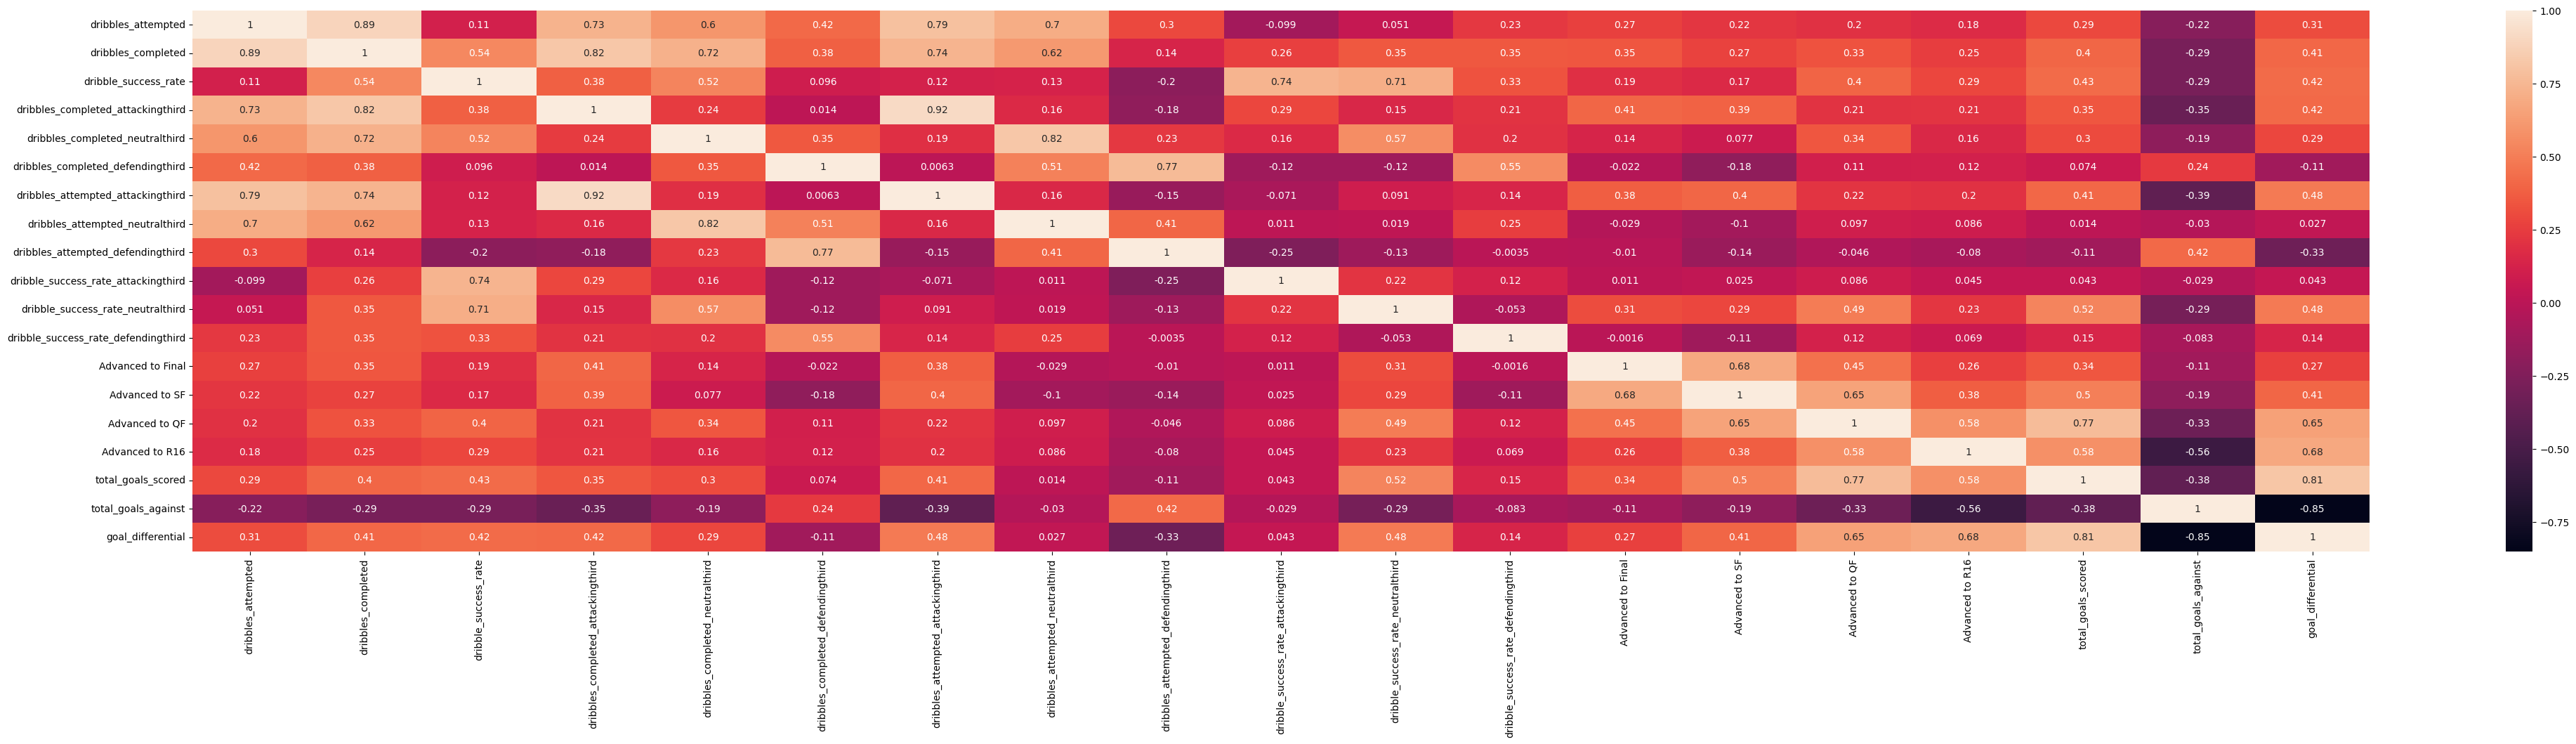

In [151]:
# let's plot a correlation heat map to see the relationship between some of the variables

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 10))

sns.heatmap(df_dribbles_team_stats.corr(), ax=ax, annot=True)


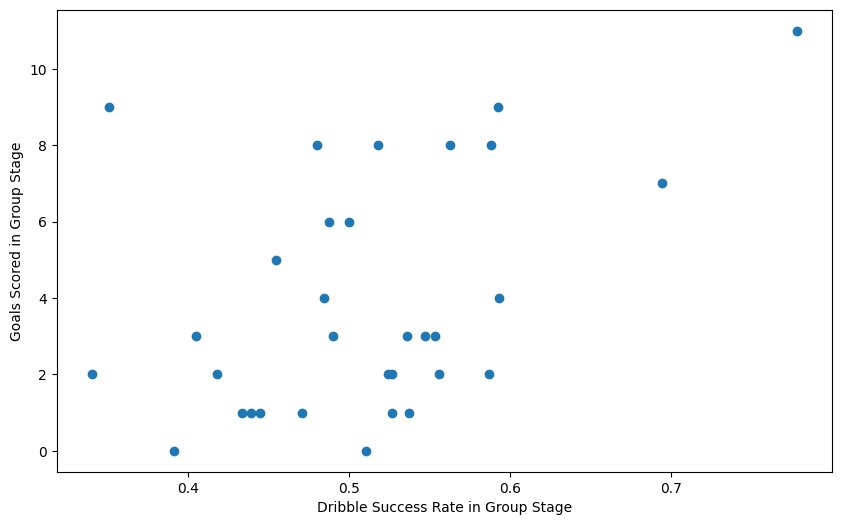

In [152]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x = df_dribbles_team_stats['dribble_success_rate'], y = df_dribbles_team_stats['total_goals_scored'],cmap = "magma")
plt.xlabel("Dribble Success Rate in Group Stage")
plt.ylabel("Goals Scored in Group Stage")
plt.show()

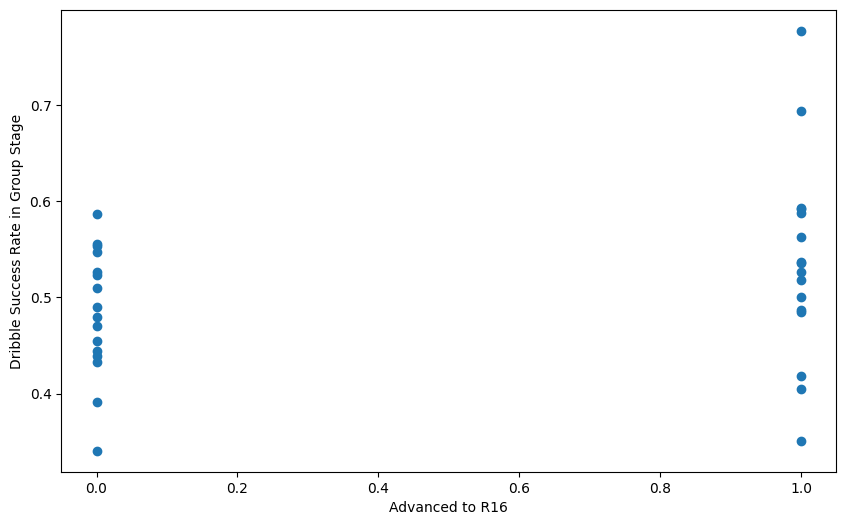

In [153]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y = df_dribbles_team_stats['dribble_success_rate'], x = df_dribbles_team_stats['Advanced to R16'],cmap = "magma")
plt.xlabel("Advanced to R16")
plt.ylabel("Dribble Success Rate in Group Stage")
plt.show()

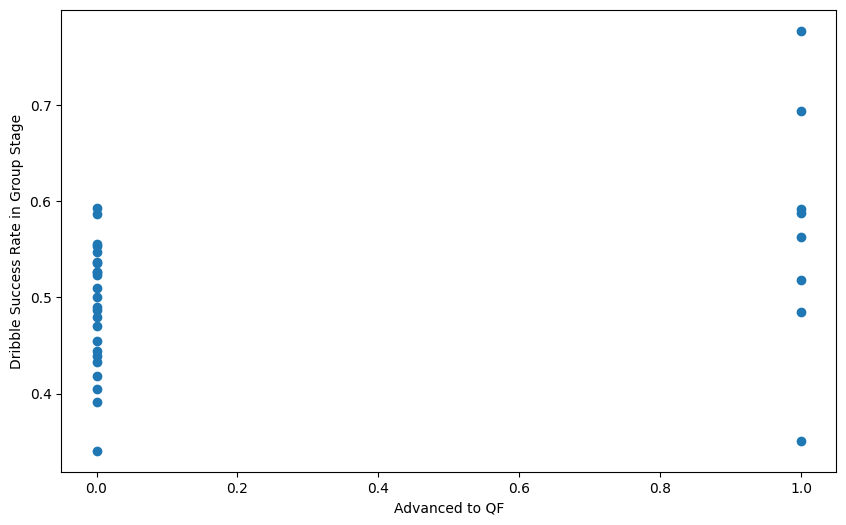

In [154]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y = df_dribbles_team_stats['dribble_success_rate'], x = df_dribbles_team_stats['Advanced to QF'],cmap = "magma")
plt.xlabel("Advanced to QF")
plt.ylabel("Dribble Success Rate in Group Stage")
plt.show()

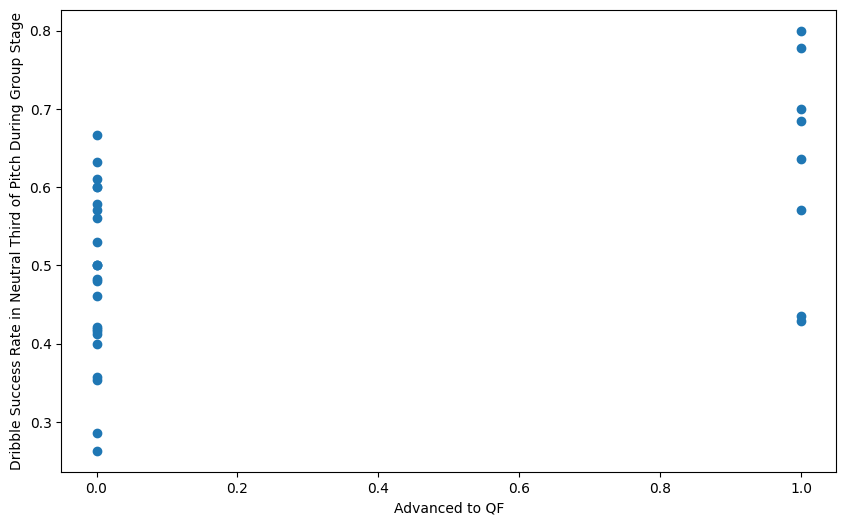

In [155]:

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y = df_dribbles_team_stats['dribble_success_rate_neutralthird'], x = df_dribbles_team_stats['Advanced to QF'],cmap = "magma")
plt.xlabel("Advanced to QF")
plt.ylabel("Dribble Success Rate in Neutral Third of Pitch During Group Stage")
plt.show()

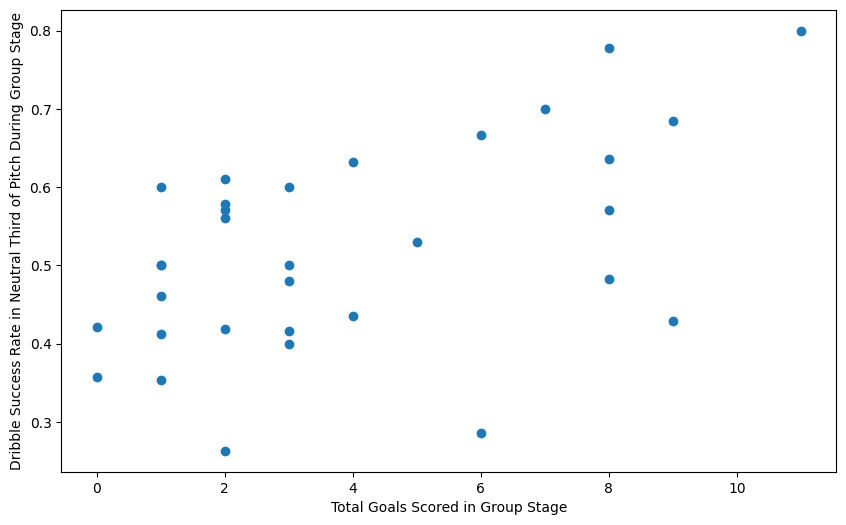

In [156]:

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y = df_dribbles_team_stats['dribble_success_rate_neutralthird'], x = df_dribbles_team_stats['total_goals_scored'],cmap = "magma")
plt.xlabel("Total Goals Scored in Group Stage")
plt.ylabel("Dribble Success Rate in Neutral Third of Pitch During Group Stage")
plt.show()

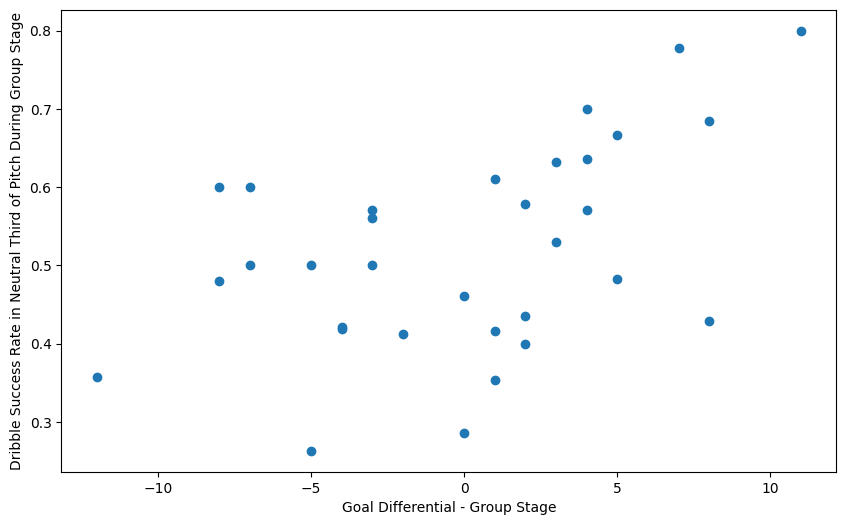

In [157]:

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y = df_dribbles_team_stats['dribble_success_rate_neutralthird'], x = df_dribbles_team_stats['goal_differential'],cmap = "magma")
plt.xlabel("Goal Differential - Group Stage")
plt.ylabel("Dribble Success Rate in Neutral Third of Pitch During Group Stage")
plt.show()

In [158]:
print("Bottom 5 Teams by Dribble Success Rate in Neutral Third of Pitch During Group Stage:")
df_neutral_success_rate = df_dribbles_team_stats.groupby('team', as_index=False)['dribble_success_rate_neutralthird'].mean().sort_values(by='dribble_success_rate_neutralthird', ascending=True)
df_neutral_success_rate.head(5)

Bottom 5 Teams by Dribble Success Rate in Neutral Third of Pitch During Group Stage:


,team,dribble_success_rate_neutralthird
4,China PR Women's,0.263158
25,South Africa Women's,0.285714
13,Jamaica Women's,0.352941
30,Vietnam Women's,0.357143
7,Denmark Women's,0.400000


In [159]:
print("Top 5 Teams by Dribble Success Rate in Neutral Third of Pitch During Group Stage:")
df_neutral_success_rate = df_dribbles_team_stats.groupby('team', as_index=False)['dribble_success_rate_neutralthird'].mean().sort_values(by='dribble_success_rate_neutralthird', ascending=False)
df_neutral_success_rate.head(5)

Top 5 Teams by Dribble Success Rate in Neutral Third of Pitch During Group Stage:


,team,dribble_success_rate_neutralthird
14,Japan Women's,0.800000
8,England Women's,0.777778
1,Australia Women's,0.700000
17,Netherlands Women's,0.684211
20,Norway Women's,0.666667


In [160]:
df_dribbles_japan = df_dribbles[df_dribbles['team'].isin(["Japan Women's"])]
df_dribbles_japan = df_dribbles_japan.join(pd.DataFrame(df_dribbles_japan.pop('location').tolist(), index=df_dribbles_japan.index, columns=["x", "y"]))
df_dribbles_japan

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,duration,under_pressure,related_events,match_id,dribble_outcome,possession_team_id,team_id,player_id,dribble_nutmeg,dribble_overrun,out,dribble_no_touch,x_location,location_bin,Defending Third,Neutral Third,Attacking Third,x,y
238,fed72d4b-aa89-4f4a-a5f5-8f4eb5da8cda,1129,1,00:22:59.735,22,59,Dribble,40,Japan Women's,From Throw In,Japan Women's,Hinata Miyazawa,Right Attacking Midfield,0.0,True,"[08e325f4-d587-4ad7-9c76-2b32a41f1fd4, 992430e...",3893822,Incomplete,1210,1210,401932,NaN,NaN,NaN,NaN,54.9,Neutral Third,0,1,0,54.9,29.4
239,839dacb5-37e5-4177-a260-9162f1d020c9,1188,1,00:23:46.699,23,46,Dribble,42,Japan Women's,Regular Play,Japan Women's,Jun Endo,Left Wing Back,0.0,True,[f23c6121-0617-451c-887d-da7d4ee4c86b],3893822,Complete,1210,1210,25608,NaN,NaN,NaN,NaN,46.2,Neutral Third,0,1,0,46.2,17.9
242,98f34fd5-5fa5-46b2-a9a8-d20b0ae52c1b,1468,1,00:30:15.885,30,15,Dribble,55,Japan Women's,Regular Play,Japan Women's,Jun Endo,Left Wing Back,0.0,True,[dabf45cc-58c9-4b5f-932f-2d380c68d991],3893822,Incomplete,1210,1210,25608,NaN,NaN,NaN,NaN,21.9,Defending Third,1,0,0,21.9,7.5
248,a0f2a092-11cd-4e9c-8c3e-95d9adf6eaaf,2135,1,00:44:50.102,44,50,Dribble,79,Japan Women's,Regular Play,Japan Women's,Riko Ueki,Center Forward,0.0,True,[6e33ca8d-6223-41ff-8a90-fbe738055d77],3893822,Complete,1210,1210,401930,NaN,NaN,NaN,NaN,51.5,Neutral Third,0,1,0,51.5,70.7
251,74537ec1-fb3d-4f3f-950d-bdbbefd93aa2,2568,2,00:05:22.143,50,22,Dribble,95,Spain Women's,Regular Play,Japan Women's,Riko Ueki,Center Forward,0.0,True,[482335c4-0cfe-4a44-927e-aa37a6a5e277],3893822,Incomplete,863,1210,401930,NaN,True,NaN,NaN,108.9,Attacking Third,0,0,1,108.9,54.3
255,bec9c47e-cb1d-4aa3-ae23-b2717cd5d39d,2824,2,00:10:10.117,55,10,Dribble,101,Spain Women's,From Corner,Japan Women's,Hikaru Naomoto,Left Attacking Midfield,0.0,True,[e31958cb-5d91-4fc6-950b-b966b6a25418],3893822,Complete,863,1210,401929,NaN,NaN,NaN,NaN,38.3,Defending Third,1,0,0,38.3,70.3
256,ba799ee2-fc01-44fe-a1bd-794d354a5f9c,3027,2,00:14:10.678,59,10,Dribble,107,Spain Women's,Regular Play,Japan Women's,Jun Endo,Left Wing Back,0.0,True,[78eb383a-42e0-410f-87db-46bcfc117c07],3893822,Complete,863,1210,25608,NaN,NaN,NaN,NaN,46.7,Neutral Third,0,1,0,46.7,20.0
264,b66f00f5-9de3-4a35-ac1b-7cdac22eb466,4296,2,00:43:02.416,88,2,Dribble,165,Japan Women's,Regular Play,Japan Women's,Aoba Fujino,Right Attacking Midfield,0.0,True,[a42ce0be-daad-485f-82fc-dfe881581b07],3893822,Incomplete,1210,1210,401925,NaN,NaN,NaN,NaN,112.1,Attacking Third,0,0,1,112.1,74.2
1891,74dadb55-7253-4722-882c-1a2d68188cc6,610,1,00:17:03.223,17,3,Dribble,36,Costa Rica Women's,Regular Play,Japan Women's,Honoka Hayashi,Left Defensive Midfield,0.0,True,[30463357-f615-46e5-b2fb-1d1c84ea165e],3893805,Incomplete,1832,1210,131653,NaN,True,NaN,NaN,31.1,Defending Third,1,0,0,31.1,57.8
1892,53f793eb-de6c-4889-a14f-e8f2acc94ec4,800,1,00:22:15.095,22,15,Dribble,46,Japan Women's,Regular Play,Japan Women's,Risa Shimizu,Right Wing Back,0.0,True,[a9325c1c-737b-450f-9eec-c6c1189545af],3893805,Complete,1210,1210,25624,NaN,NaN,NaN,NaN,51.1,Neutral Third,0,1,0,51.1,72.9


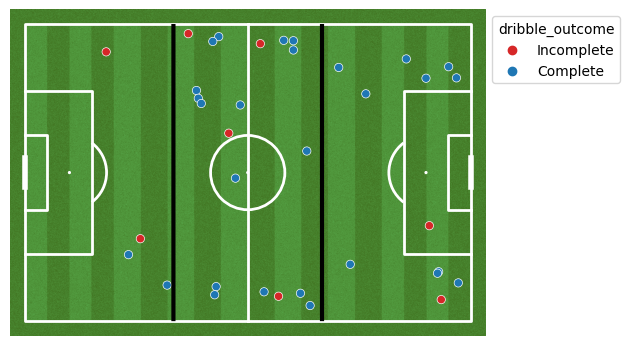

In [179]:
from mplsoccer.pitch import Pitch
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True, pitch_length=120, pitch_width=80)
fig, ax = pitch.draw()
pitch.lines(xstart = 40, ystart = 0, xend = 40, yend = 80, color='black', linewidth = 3, ax=ax)
pitch.lines(xstart = 80, ystart = 0, xend = 80, yend = 80, color='black', linewidth = 3, ax=ax)


palette = {
    'Complete': 'tab:blue',
    'Incomplete': 'tab:red',
}

sns.scatterplot(x="x", y="y", data=df_dribbles_japan, hue = "dribble_outcome", palette = palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [162]:
df_dribbles_china = df_dribbles[df_dribbles['team'].isin(["China PR Women's"])]
df_dribbles_china = df_dribbles_china.join(pd.DataFrame(df_dribbles_china.pop('location').tolist(), index=df_dribbles_china.index, columns=["x", "y"]))
df_dribbles_china

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,duration,under_pressure,related_events,match_id,dribble_outcome,possession_team_id,team_id,player_id,dribble_nutmeg,dribble_overrun,out,dribble_no_touch,x_location,location_bin,Defending Third,Neutral Third,Attacking Third,x,y
909,03352431-a177-42b1-a8a3-628e2c8381e6,29,1,00:00:41.544,0,41,Dribble,4,China PR Women's,Regular Play,China PR Women's,Qiaozhu Chen,Left Back,0.0,True,[9f9f58da-04fd-4185-9438-03b7b0a3a7ae],3893813,Incomplete,1207,1207,131583,NaN,NaN,NaN,NaN,74.1,Neutral Third,0,1,0,74.1,5.1
910,6e8b91af-a77d-4dfa-934a-e1a5689d9996,217,1,00:05:47.584,5,47,Dribble,15,China PR Women's,Regular Play,China PR Women's,Mengwen Li,Right Back,0.0,True,[4066ad9b-60d0-4ed9-befa-a9b334f13ca1],3893813,Incomplete,1207,1207,131575,NaN,NaN,NaN,NaN,68.6,Neutral Third,0,1,0,68.6,76.6
911,459aa112-c7ce-46ae-961d-5cdb25fa7006,223,1,00:05:52.720,5,52,Dribble,15,China PR Women's,Regular Play,China PR Women's,Shanshan Wang,Right Center Back,0.0,True,[c2f1894b-c0ad-488a-9ee9-cf748cee1cff],3893813,Incomplete,1207,1207,25485,NaN,NaN,NaN,NaN,63.0,Neutral Third,0,1,0,63.0,55.8
912,a0afc455-90a1-4247-bb8b-e40c585f7692,289,1,00:07:29.761,7,29,Dribble,17,China PR Women's,From Corner,China PR Women's,Linyan Zhang,Left Wing,0.0,True,[fb18d656-568e-43da-9631-5c3281c2e439],3893813,Incomplete,1207,1207,402025,NaN,NaN,NaN,NaN,102.8,Attacking Third,0,0,1,102.8,9.5
914,ee3f6d93-c315-4548-8707-e6868b71bf8d,320,1,00:08:10.594,8,10,Dribble,19,Haiti Women's,From Throw In,China PR Women's,Linyan Zhang,Left Wing,0.0,True,[8a1afbb0-699a-4802-b7a9-d8fb1676d05e],3893813,Incomplete,2355,1207,402025,NaN,NaN,NaN,NaN,74.4,Neutral Third,0,1,0,74.4,7.7
919,760febcb-d75c-47c9-9a72-6b6655479514,801,1,00:23:06.059,23,6,Dribble,53,Haiti Women's,From Goal Kick,China PR Women's,Linyan Zhang,Left Wing,0.0,True,"[2c5f415c-d906-4966-9f86-48c4a60a65cf, 5c5de5b...",3893813,Incomplete,2355,1207,402025,NaN,NaN,NaN,NaN,72.0,Neutral Third,0,1,0,72.0,26.8
927,345dee0b-f755-48d1-8270-25f23b6475b7,1087,1,00:34:45.752,34,45,Dribble,71,China PR Women's,Regular Play,China PR Women's,Chengshu Wu,Right Midfield,0.0,True,[de8b013a-2693-4d63-9ab3-6e540f0e79a4],3893813,Incomplete,1207,1207,402019,NaN,NaN,NaN,NaN,63.3,Neutral Third,0,1,0,63.3,72.5
928,c4940c5a-1658-4821-b7ab-f365695511d4,1347,1,00:40:42.611,40,42,Dribble,84,China PR Women's,Regular Play,China PR Women's,Linyan Zhang,Center Forward,0.0,True,[7939f42f-d12f-4615-bae0-c8fff81acb95],3893813,Complete,1207,1207,402025,NaN,True,NaN,NaN,27.5,Defending Third,1,0,0,27.5,55.8
930,a3ae13af-6649-45a7-8eb5-40eff31ee7f6,1447,1,00:43:25.803,43,25,Dribble,88,China PR Women's,Regular Play,China PR Women's,Chengshu Wu,Right Midfield,0.0,True,"[642d37ed-65ba-4130-87e1-8bca2a1c4c99, 832bc2b...",3893813,Complete,1207,1207,402019,NaN,NaN,NaN,NaN,98.1,Attacking Third,0,0,1,98.1,57.0
931,e0b2b739-008c-4186-a5c4-1e650593bc4b,1562,1,00:45:47.969,45,47,Dribble,92,China PR Women's,From Throw In,China PR Women's,Lina Yang,Left Defensive Midfield,0.0,True,[22a15709-ebed-4aa4-ae37-05aaaed00d0d],3893813,Incomplete,1207,1207,131579,NaN,NaN,NaN,NaN,98.8,Attacking Third,0,0,1,98.8,13.9


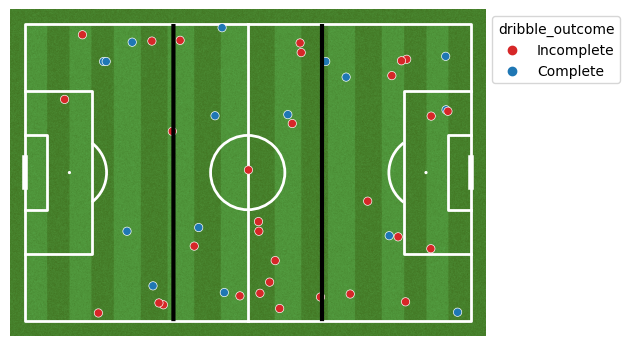

In [178]:
from mplsoccer.pitch import Pitch
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True, pitch_length=120, pitch_width=80)
fig, ax = pitch.draw()
pitch.lines(xstart = 40, ystart = 0, xend = 40, yend = 80, color='black', linewidth = 3, ax=ax)
pitch.lines(xstart = 80, ystart = 0, xend = 80, yend = 80, color='black', linewidth = 3, ax=ax)


palette = {
    'Complete': 'tab:blue',
    'Incomplete': 'tab:red',
}

sns.scatterplot(x="x", y="y", data=df_dribbles_china, hue = "dribble_outcome", palette = palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [192]:
# parameter names of the statistics we want to show
params = ["total_goals_scored", "total_goals_conceeded", "dribble_success_rate", "dribble_success_rate_attackingthird", 
          "dribble_success_rate_neutralthird", "dribble_success_rate_defendingthird", "dribbles_attempted",
          "Advanced to R16"]

# The lower and upper boundaries for the statistics
low =  [0.00, 0.0, 0.0, 0, 0.0, 0, 0, 0]
high = [15, 15, 1.00, 1.00, 1.00, 1.00, 85, 1]

# Add anything to this list where having a lower number is better
# this flips the statistic
lower_is_better = ['total_goals_conceeded']


In [193]:
from mplsoccer import Radar, FontManager, grid
radar = Radar(params, low, high,
              lower_is_better=lower_is_better,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)

In [194]:
URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

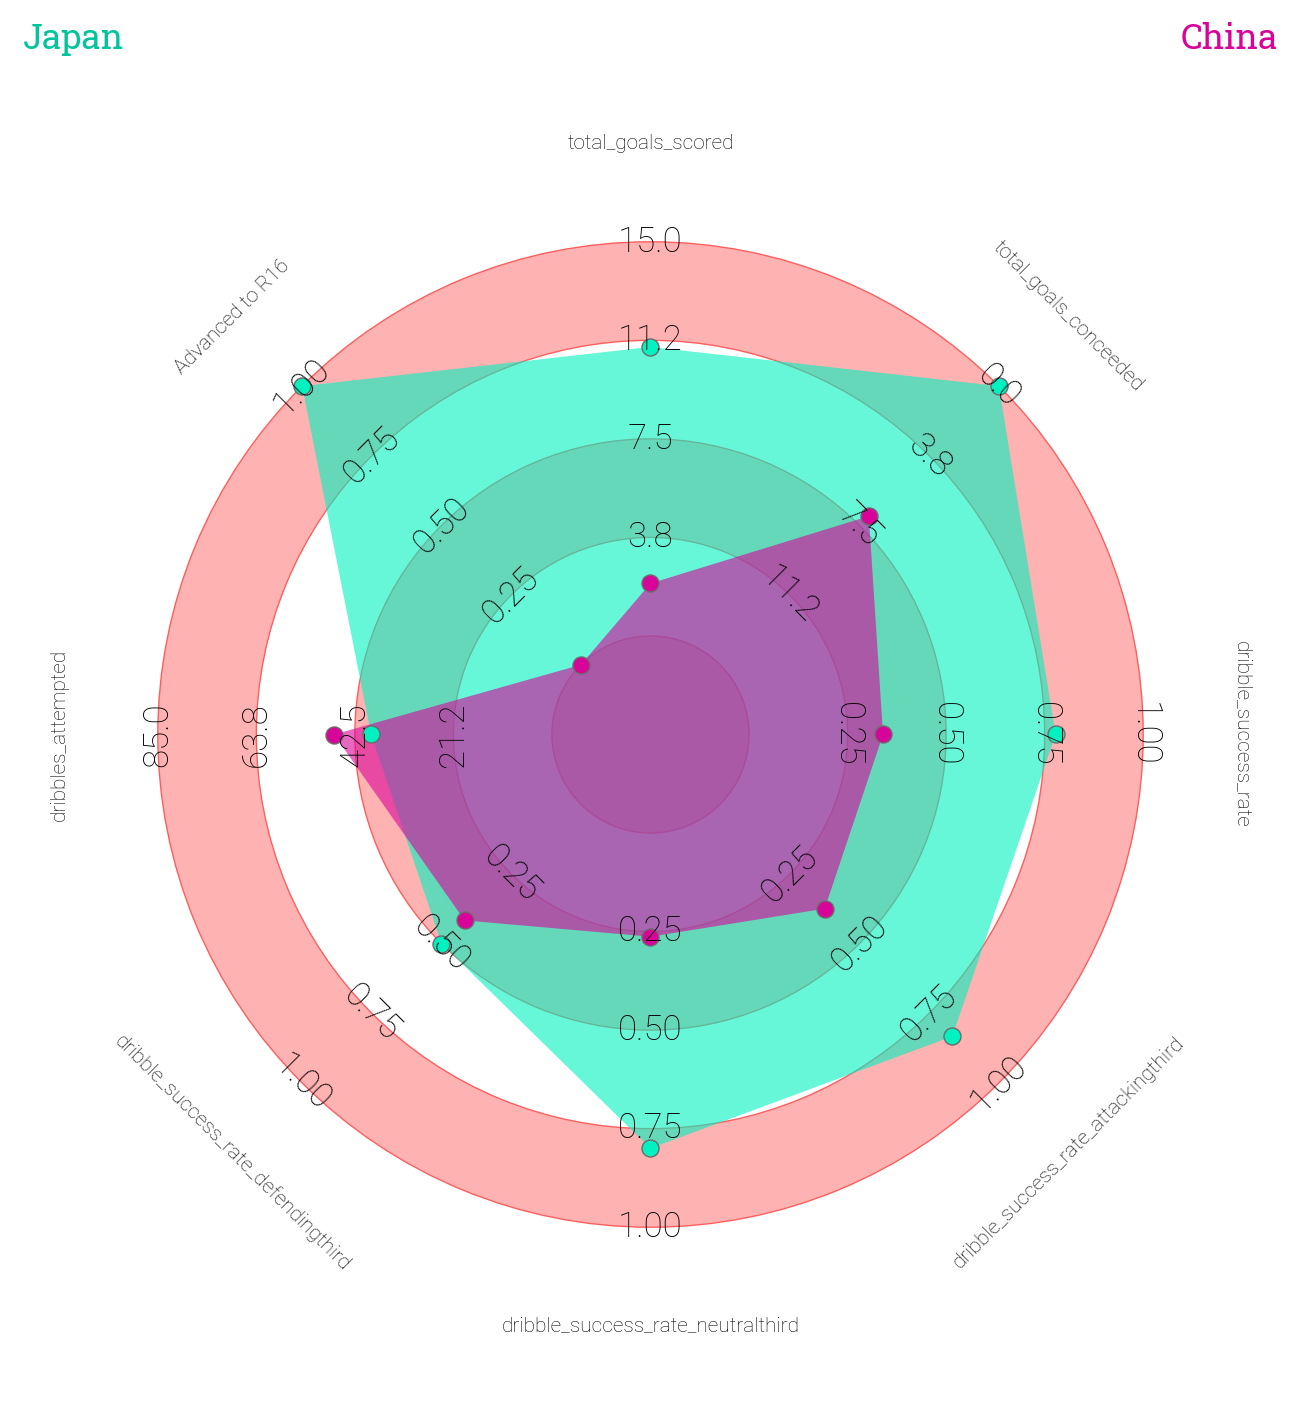

In [199]:
japan_values = [11, 0, 0.778, 0.833, 0.800, 0.500, 39, 1]
china_values = [2, 7, 0.340, 0.375, 0.263, 0.417, 47, 0]

# creating the figure using the grid function from mplsoccer:
fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot radar
radar.setup_axis(ax=axs['radar'])  # format axis as a radar
rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#fc5f5f')
radar_output = radar.draw_radar_compare(japan_values, china_values, ax=axs['radar'],
                                        kwargs_radar={'facecolor': '#00f2c1', 'alpha': 0.6},
                                        kwargs_compare={'facecolor': '#d80499', 'alpha': 0.6})
radar_poly, radar_poly2, vertices1, vertices2 = radar_output
range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=25,
                                       fontproperties=robotto_thin.prop)
param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=15,
                                       fontproperties=robotto_thin.prop)
axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
                     c='#00f2c1', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
                     c='#d80499', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)

# adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
# Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
title1_text = axs['title'].text(0.01, 0.65, 'Japan', fontsize=25, color='#01c49d',
                                fontproperties=robotto_bold.prop, ha='left', va='center')
title2_text = axs['title'].text(0.99, 0.65, 'China', fontsize=25,
                                fontproperties=robotto_bold.prop,
                                ha='right', va='center', color='#d80499')


In [164]:
# Top 25 players by attempted dribbles during 2023 Women's World Cup group stage
df_dribbles['player'].value_counts().nlargest(25, keep = 'all')

Sakina Ouzraoui Diki               28
Salma Paralluelo Ayingono          24
Klara Bühl                         23
Racheal Kundananji                 21
Estefanía Romina Banini Ruiz       20
Jéssica da Silva                   19
Sophia Olivia Smith                18
Mayra Tatiana Ramírez Ramírez      18
Caroline Graham Hansen             16
Fatima Zahra Tagnaout              15
Jule Brand                         15
Lisa Boattin                       15
Jennifer Hermoso Fuentes           14
Jody Brown                         14
Johanna Rytting-Kaneryd            13
Nérilia Mondesir                   13
Marta Alexandra Cox Villarreal     13
Ashley Elizabeth Marie Lawrence    12
Thembi Kgatlana                    12
Antionette Oyedupe Payne           11
Linda Lizeth Caicedo Alegría       11
Giulia Dragoni                     11
Barbra Banda                       11
Caitlin Jade Foord                 11
Lieke Martens                      11
Khadija Monifa Shaw                11
María Floren

In [165]:
# Top 25 teams by attempted dribbles during 2023 Women's World Cup
df_dribbles['team'].value_counts().nlargest(25, keep = 'all')

Spain Women's                  85
Morocco Women's                79
Germany Women's                75
Portugal Women's               75
Brazil Women's                 66
Colombia Women's               64
Canada Women's                 63
United States Women's          59
Sweden Women's                 57
France Women's                 56
Italy Women's                  56
Nigeria Women's                56
Jamaica Women's                54
Argentina Women's              54
Netherlands Women's            54
Zambia Women's                 53
Haiti Women's                  49
Panama Women's                 49
Australia Women's              49
England Women's                48
China PR Women's               47
Denmark Women's                42
Republic of Ireland Women's    41
Norway Women's                 40
South Africa Women's           39
Name: team, dtype: int64

In [166]:
# Top 25 positions by attempted dribbles during 2023 Women's World Cup group stage
df_dribbles['position'].value_counts().nlargest(25, keep = 'all')

Left Wing                    186
Right Wing                   167
Center Forward               153
Left Back                    108
Center Attacking Midfield    108
Right Midfield               105
Right Back                   101
Left Midfield                 91
Left Defensive Midfield       86
Right Defensive Midfield      86
Left Center Midfield          68
Right Center Forward          61
Left Center Forward           59
Right Center Midfield         57
Left Wing Back                42
Right Wing Back               41
Right Center Back             41
Left Center Back              24
Center Defensive Midfield     24
Right Attacking Midfield      11
Goalkeeper                     3
Left Attacking Midfield        2
Center Back                    2
Name: position, dtype: int64

In [167]:
df_dribbles_completed = df_dribbles[df_dribbles['dribble_outcome'] == "Complete"]
df_dribbles_completed

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,under_pressure,related_events,match_id,dribble_outcome,possession_team_id,team_id,player_id,dribble_nutmeg,dribble_overrun,out,dribble_no_touch,x_location,location_bin,Defending Third,Neutral Third,Attacking Third
103,236a425f-4b77-4fd9-9471-4309701b84cd,46,1,00:00:54.322,0,54,Dribble,4,Spain Women's,From Throw In,Spain Women's,Aitana Bonmati Conca,Right Center Midfield,"[95.4, 77.6]",0.0,True,[82839390-585b-4b0e-8114-0b6eaa66201a],3893806,Complete,863,863,15284,NaN,NaN,NaN,NaN,95.4,Attacking Third,0,0,1
109,246d265c-02c5-44cd-9b82-5ef3f3b3c9f4,526,1,00:14:02.680,14,2,Dribble,30,Spain Women's,Regular Play,Spain Women's,Salma Paralluelo Ayingono,Right Wing,"[67.0, 78.9]",0.0,True,[1cd22005-f180-4af8-ade3-5e525bae1e71],3893806,Complete,863,863,222682,NaN,NaN,NaN,NaN,67.0,Neutral Third,0,1,0
110,e17efbec-13c1-4ead-9ac5-1a05f1a1e8d0,834,1,00:20:47.923,20,47,Dribble,47,Spain Women's,From Throw In,Spain Women's,Salma Paralluelo Ayingono,Right Wing,"[88.4, 52.1]",0.0,True,[dbc4293a-cb6d-45cf-bd60-86661d0ddb67],3893806,Complete,863,863,222682,NaN,NaN,NaN,NaN,88.4,Attacking Third,0,0,1
114,760ff6b1-44e0-42d7-8529-1aa74184af6b,939,1,00:23:00.357,23,0,Dribble,54,Spain Women's,Regular Play,Spain Women's,Olga Carmona García,Left Back,"[47.5, 18.1]",0.0,True,[08c4bce8-39c6-4aa6-bbe1-d1283cdbc812],3893806,Complete,863,863,49836,NaN,NaN,NaN,NaN,47.5,Neutral Third,0,1,0
115,14ebf15f-d12c-4de1-943e-c06afc6d99c4,975,1,00:23:45.918,23,45,Dribble,55,Spain Women's,From Goal Kick,Spain Women's,Alexia Putellas Segura,Left Center Midfield,"[97.2, 31.0]",0.0,True,[fbffe9da-cdd2-4191-bca2-562b35c09f2f],3893806,Complete,863,863,10143,NaN,NaN,NaN,NaN,97.2,Attacking Third,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,abee1970-078f-42a3-89a2-334d0e8aa00c,3671,2,00:44:20.423,89,20,Dribble,192,Zambia Women's,Regular Play,Zambia Women's,Racheal Kundananji,Left Midfield,"[74.5, 14.9]",0.0,True,[e536c18c-297f-42c0-8d01-48d16f20f99e],3893793,Complete,6045,6045,32854,NaN,NaN,NaN,NaN,74.5,Neutral Third,0,1,0
2145,6d18e83e-39d5-4777-b1e1-a80cc3f5f9c7,3675,2,00:44:23.987,89,23,Dribble,192,Zambia Women's,Regular Play,Zambia Women's,Racheal Kundananji,Left Midfield,"[91.7, 24.1]",0.0,True,[11ea724c-d49e-4c9c-94aa-0e9eda8d0610],3893793,Complete,6045,6045,32854,NaN,NaN,NaN,NaN,91.7,Attacking Third,0,0,1
2146,55b0b563-59d9-40bb-a5a8-0758d1ec0158,3752,2,00:45:45.600,90,45,Dribble,195,Zambia Women's,Regular Play,Zambia Women's,Evarine Susan Katongo,Left Center Midfield,"[38.6, 19.8]",0.0,True,"[1f3eb53c-47a4-458f-9095-f0a26a043e78, 83ac039...",3893793,Complete,6045,6045,131631,NaN,NaN,NaN,NaN,38.6,Defending Third,1,0,0
2147,5476452a-37cd-4c2c-b031-eec37c1157c9,3895,2,00:49:44.827,94,44,Dribble,201,Japan Women's,From Throw In,Japan Women's,Remina Chiba,Center Forward,"[111.1, 67.1]",0.0,True,[a60f4111-493b-4fed-b04d-fae95ebbe983],3893793,Complete,1210,1210,401933,NaN,NaN,NaN,NaN,111.1,Attacking Third,0,0,1


In [168]:
# Top 25 players by completed dribbles during 2023 Women's World Cup group stage
df_dribbles_completed['player'].value_counts().nlargest(25, keep = 'all')

Salma Paralluelo Ayingono          16
Estefanía Romina Banini Ruiz       12
Sakina Ouzraoui Diki               12
Racheal Kundananji                 11
Klara Bühl                         11
Caroline Graham Hansen             10
Sophia Olivia Smith                 9
Jéssica da Silva                    9
Mayra Tatiana Ramírez Ramírez       9
Kathrine Møller Kühl                8
Caitlin Jade Foord                  8
Jennifer Hermoso Fuentes            8
Adriana Leal da Silva               8
Marta Alexandra Cox Villarreal      8
Giulia Dragoni                      8
Lisa Boattin                        8
Lieke Martens                       7
Jody Brown                          7
Jule Brand                          7
Antionette Oyedupe Payne            7
Nérilia Mondesir                    6
Ana Borges                          6
Batcheba Louis                      6
Katie McCabe                        6
Thembi Kgatlana                     6
María Florencia Bonsegundo          6
Jun Endo    

In [169]:
# Top 25 teams by completed dribbles during 2023 Women's World Cup group stage
df_dribbles_completed['team'].value_counts().nlargest(25, keep = 'all')

Spain Women's                  50
Portugal Women's               44
Germany Women's                36
United States Women's          35
Australia Women's              34
Canada Women's                 33
Morocco Women's                33
Netherlands Women's            32
Italy Women's                  31
Colombia Women's               31
Argentina Women's              30
Brazil Women's                 30
Nigeria Women's                30
Jamaica Women's                29
France Women's                 29
Zambia Women's                 29
Japan Women's                  28
England Women's                27
Haiti Women's                  25
Panama Women's                 24
Norway Women's                 20
Switzerland Women's            20
Sweden Women's                 20
South Africa Women's           19
Republic of Ireland Women's    18
Name: team, dtype: int64

In [170]:
# Top 25 positions by completed dribbles during 2023 Women's World Cup group stage
df_dribbles_completed['position'].value_counts().nlargest(25, keep = 'all')

Left Wing                    88
Right Wing                   77
Center Forward               66
Center Attacking Midfield    66
Right Midfield               54
Left Back                    52
Right Back                   52
Right Defensive Midfield     48
Left Midfield                47
Left Center Midfield         46
Left Defensive Midfield      39
Right Center Midfield        31
Left Center Forward          28
Right Center Forward         27
Right Center Back            26
Left Wing Back               26
Right Wing Back              19
Left Center Back             17
Center Defensive Midfield    12
Right Attacking Midfield      6
Goalkeeper                    3
Left Attacking Midfield       2
Center Back                   2
Name: position, dtype: int64

In [203]:
events

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_no_touch,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_lost_in_play,goalkeeper_outcome,goalkeeper_penalty_saved_to_post,goalkeeper_position,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,goalkeeper_success_in_play,goalkeeper_success_out,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,player_off_permanent,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_redirect,shot_saved_off_target,shot_saved_to_post,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b9a8a25-9c40-4dfd-bd2d-f4e1249a34bd,1,NaN,NaN,NaN,3904629,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,1,Australia Women's,1205,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 442, 'lineup': [{'player': {'id'...",Australia Women's,1205,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01616711-c83c-4cf9-8dbc-3e3d27d0bcdd,2,NaN,NaN,NaN,3904629,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,1,Australia Women's,1205,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 3412, 'lineup': [{'player': {'id...",England Women's,865,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73d302be-c474-47b0-b465-d276046f96a5,1,NaN,NaN,NaN,3906390,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,1,Spain Women's,863,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Spain Women's,863,00:00:00.000,Starting XI,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cbad5dd0-01cd-4be0-8693-15942b19d363,2,NaN,NaN,NaN,3906390,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,NaN,1,

In [208]:
events['interception_outcome'].value_counts()

Won                482
Lost In Play       325
Success In Play    284
Lost Out           270
Success Out         11
Name: interception_outcome, dtype: int64